# Weight Decay

In [1]:
!pip install mxnet
!pip install d2l

     |████████████████████████████████| 25.4MB 1.3MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Created wheel for d2l: filename=d2l-0.10.1-cp36-none-any.whl size=16622 sha256=e0160de1a9784a898403857c55994515b286120663e6b8b362c579a90d877fba
  Stored in directory: /root/.cache/pip/wheels/60/35/5d/df7f13dd4b012de688ffcc516091c6cd67c765dc64c9d1f43f
Successfully built d2l


In [2]:
!pip install d2l
!pip install mxnet

%matplotlib inline
import d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

ERROR: Invalid requirement: 'd2l!pip'


## High-dimensional Linear Regression

$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01)$$

In [0]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 1
true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05

train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## Weight Decay from Scratch

### Initialize Model Parameters

In [0]:
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    w.attach_grad()
    b.attach_grad()
    return [w, b]

### Define Squared $\ell_2$ Norm Penalty

In [0]:
def l2_penalty(w):
    return (w**2).sum() / 2

### Define Training and Testing

In [0]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], legend=['train', 'test'])
    for epoch in range(1, num_epochs+1):
        for X, y in train_iter:
            with autograd.record():
                # The L2 norm penalty term has been added
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        if epoch % 5 == 0:
            animator.add(epoch+1, (d2l.evaluate_loss(net, train_iter, loss),
                                   d2l.evaluate_loss(net, test_iter, loss)))
    print('l2 norm of w:', w.norm().asscalar())

### Training without Regularization

l2 norm of w: 13.949474


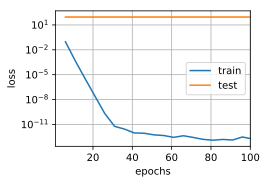

In [7]:
train(lambd=0)

### Using Weight Decay

l2 norm of w: 0.042377405


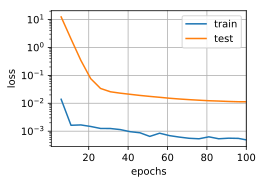

In [8]:
train(lambd=3)

## Weight Decay in Gluon
Because weight decay is ubiquitous in neural network optimization, Gluon makes it especially convenient, integrating weight decay into the optimization algorithm itself for easy use in combination with any loss function. Moreover, this integration serves a computational benefit, allowing implementation tricks to add weight decay to the algorithm, without any additional computational overhead. Since the weight decay portion of the update depends only on the current value of each parameter, and the optimizer must to touch each parameter once anyway.

In the following code, we specify the weight decay hyper-parameter directly through the wd parameter when instantiating our Trainer. By default, Gluon decays both weights and biases simultaneously. Note that we can have different optimizers for different sets of parameters. For instance, we can have one Trainer with weight decay for the weights 𝐰 and another without weight decay to take care of the bias 𝑏

In [0]:
def train_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    loss = gluon.loss.L2Loss()
    num_epochs, lr = 100, 0.003
    # The weight parameter has been decayed. Weight names generally end with
    # "weight".
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd',
                              {'learning_rate': lr, 'wd': wd})
    # The bias parameter has not decayed. Bias names generally end with "bias"
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd',
                              {'learning_rate': lr})
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], legend=['train', 'test'])
    for epoch in range(1, num_epochs+1):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            # Call the step function on each of the two Trainer instances to
            # update the weight and bias separately
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        if epoch % 5 == 0:
            animator.add(epoch+1, (d2l.evaluate_loss(net, train_iter, loss),
                                   d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())


### Using Weight Decay

L2 norm of w: 13.989467


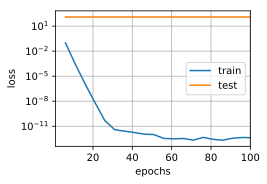

In [10]:
train_gluon(wd=0)

### Training without Regularization

L2 norm of w: 0.046018817


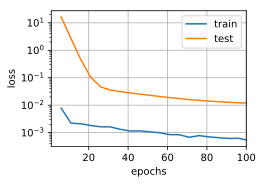

In [11]:
train_gluon(wd=3)

In [0]:
## Weight Decay in Keras


In [12]:
import pandas as pd

import numpy as np
import keras

from matplotlib import pyplot as plt

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras import initializers

from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

%matplotlib inline

Using TensorFlow backend.


In [16]:
train_data


(
 [[ 2.2122064   0.7740038   1.0434403  ... -0.662727    1.8137852
   -2.1109133 ]
  [-1.1784948  -0.8764637  -0.08521592 ...  1.7288173   0.23753463
   -0.16727363]
  [ 0.1533563  -0.735794   -0.54260164 ... -0.7586511  -0.01373923
   -1.1598114 ]
  ...
  [ 1.7225602   1.0961148  -0.88117856 ...  0.3445677  -0.694543
    1.0060185 ]
  [ 0.10266163 -1.2117697  -1.9722325  ... -0.17292506 -0.5693115
   -1.2255299 ]
  [ 1.066639    0.06402884  1.3270504  ... -0.49581167  0.9068953
    0.89773697]]
 <NDArray 20x200 @cpu(0)>, 
 [[ 0.07004381]
  [-0.12249257]
  [ 0.07067867]
  [-0.00525122]
  [ 0.29120398]
  [ 0.05239628]
  [-0.01568439]
  [ 0.14645976]
  [ 0.17885822]
  [ 0.09211619]
  [ 0.22740202]
  [ 0.32770762]
  [ 0.09681505]
  [ 0.24453439]
  [ 0.21807861]
  [ 0.07747531]
  [ 0.14817505]
  [ 0.17502461]
  [ 0.04844178]
  [ 0.40326297]]
 <NDArray 20x1 @cpu(0)>)

# KERAS IMPLEMENTATION

In [0]:

from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers, initializers, optimizers

from matplotlib import pyplot as plt


# Representing features as numpy vectors
train_features = train_data[0].asnumpy()
test_features = test_data[0].asnumpy()
train_labels = train_data[1].asnumpy()
test_labels = test_data[1].asnumpy()

##No Regularization

In [26]:
model = Sequential()
model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=1),
                 input_shape=(200,)))
sgd = optimizers.SGD()
model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['mse'])
history = model.fit(train_features, train_labels, epochs=100, verbose=2, validation_split=0.2)
test_predictions = model.predict(test_features)

Train on 16 samples, validate on 4 samples
Epoch 1/100
 - 0s - loss: 308.0861 - mean_squared_error: 308.0861 - val_loss: 255.8234 - val_mean_squared_error: 255.8234
Epoch 2/100
 - 0s - loss: 168.1434 - mean_squared_error: 168.1434 - val_loss: 253.7611 - val_mean_squared_error: 253.7611
Epoch 3/100
 - 0s - loss: 94.6061 - mean_squared_error: 94.6061 - val_loss: 254.0418 - val_mean_squared_error: 254.0418
Epoch 4/100
 - 0s - loss: 54.5798 - mean_squared_error: 54.5798 - val_loss: 255.4935 - val_mean_squared_error: 255.4935
Epoch 5/100
 - 0s - loss: 32.1261 - mean_squared_error: 32.1261 - val_loss: 257.4425 - val_mean_squared_error: 257.4425
Epoch 6/100
 - 0s - loss: 19.2134 - mean_squared_error: 19.2134 - val_loss: 259.5092 - val_mean_squared_error: 259.5092
Epoch 7/100
 - 0s - loss: 11.6380 - mean_squared_error: 11.6380 - val_loss: 261.4883 - val_mean_squared_error: 261.4883
Epoch 8/100
 - 0s - loss: 7.1229 - mean_squared_error: 7.1229 - val_loss: 263.2796 - val_mean_squared_error: 263.

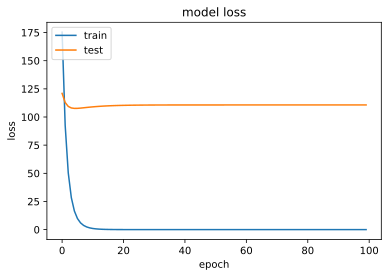

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##L2 Regularization

In [25]:
model = Sequential()
model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=1),
                kernel_regularizer=regularizers.l2(1), input_shape=(200,)))
sgd = optimizers.SGD()
model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['mse'])
history = model.fit(train_features, train_labels, epochs=100, verbose=2, validation_split=0.2)
test_predictions = model.predict(test_features)

Train on 16 samples, validate on 4 samples
Epoch 1/100
 - 0s - loss: 256.0862 - mean_squared_error: 73.1018 - val_loss: 261.6584 - val_mean_squared_error: 88.4150
Epoch 2/100
 - 0s - loss: 211.8035 - mean_squared_error: 38.5601 - val_loss: 251.8586 - val_mean_squared_error: 86.8032
Epoch 3/100
 - 0s - loss: 185.9107 - mean_squared_error: 20.8553 - val_loss: 242.8676 - val_mean_squared_error: 85.0723
Epoch 4/100
 - 0s - loss: 169.3018 - mean_squared_error: 11.5066 - val_loss: 234.2921 - val_mean_squared_error: 83.1480
Epoch 5/100
 - 0s - loss: 157.5922 - mean_squared_error: 6.4481 - val_loss: 225.9616 - val_mean_squared_error: 81.0301
Epoch 6/100
 - 0s - loss: 148.5889 - mean_squared_error: 3.6573 - val_loss: 217.8134 - val_mean_squared_error: 78.7511
Epoch 7/100
 - 0s - loss: 141.1565 - mean_squared_error: 2.0941 - val_loss: 209.8345 - val_mean_squared_error: 76.3540
Epoch 8/100
 - 0s - loss: 134.6887 - mean_squared_error: 1.2081 - val_loss: 202.0327 - val_mean_squared_error: 73.8817
E

In [20]:
history.params

{'batch_size': 32,
 'do_validation': True,
 'epochs': 100,
 'metrics': ['loss', 'val_loss'],
 'samples': 16,
 'steps': None,
 'verbose': 2}

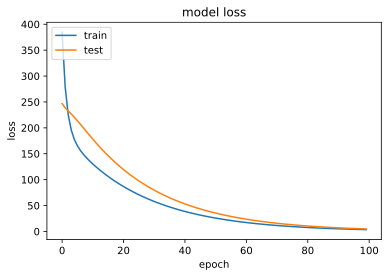

In [19]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()